#CRAWL PRICE, TRADING VOLUME, TRANSACTION VOLUME


In [ ]:
! pip install cryptocmd
! pip install git+git://github.com/guptarohit/cryptoCMD.git

     |████████████████████████████████| 48 kB 2.3 MB/s 
  Cloning git://github.com/guptarohit/cryptoCMD.git to /tmp/pip-req-build-ojm_zmgy
  Running command git clone -q git://github.com/guptarohit/cryptoCMD.git /tmp/pip-req-build-ojm_zmgy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
 import numpy as np

In [ ]:
start = "2015-08-01"#'2017-01-01'
end = "2021-12-01"#'2019-11-23'

In [ ]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
from cryptocmd import CmcScraper
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
scraper = CmcScraper('BTC',"01-08-2015","12-12-2021") # initialise scraper without passing time interv
headers, data = scraper.get_data()
#scraper.export_csv('btc_all_time.csv')   

df_price = scraper.get_dataframe().sort_index(ascending=False)
price=df_price["Close"].values.tolist()
df_price=df_price.reset_index().drop(["index"],axis=1)

In [ ]:
from pandas.core.frame import DataFrame
st=df_price.Close.to_list()
dates = df_price[0:len(df_price["Date"])]["Date"]
price_o=df_price.Open.to_list()
vt=df_price.Volume.to_list()


c={"dates":dates,"st" : st,
   "vt" : vt}#将列表a，b转换成字典
data=DataFrame(c)#将字典转换成为数据框
data["rt"]=np.log(data.st).shift(1)

In [ ]:
data['sigma'] = data['rt'].ewm(adjust=False, ignore_na=True,alpha=0.94).mean()

In [ ]:
data=data[2100:2315]

In [ ]:
data

,dates,st,vt,rt,sigma
2100,2021-05-01,57828.050632,4.283643e+10,10.963882,10.959442
2101,2021-05-02,56631.077413,3.817741e+10,10.965229,10.964882
2102,2021-05-03,57200.291223,5.171314e+10,10.944313,10.945547
2103,2021-05-04,53333.537753,6.856471e+10,10.954314,10.953788
2104,2021-05-05,57424.005948,6.924132e+10,10.884321,10.888489
...,...,...,...,...,...
2310,2021-11-27,54815.079305,3.056086e+10,10.888740,10.892694
2311,2021-11-28,57248.458376,2.811689e+10,10.911721,10.910579
2312,2021-11-29,57806.566215,3.237084e+10,10.955156,10.952481
2313,2021-11-30,57005.425474,3.670859e+10,10.964858,10.964115


#Crawl Comments from Reddit

In [ ]:
!pip install praw

In [ ]:
import pandas as pd
import requests
import json

class PushShift:

    def __init__(self):
        self.after = ''
        self.before = ''
        self.sub = ''
        self.query = ''

    def getPushshiftData(self,*args):
        url = 'https://api.pushshift.io/reddit/search/submission'
        #case: arg[0] = unix timestamp and arg[1] is subreddit
        if len(args) == 2 and self.representsInt(args[0]) and isinstance(args[1],str):
            after, sub = args
            endpoints = {"size":"1000", "after":str(after), "subreddit":str(sub)}
            r = requests.get(url, params=endpoints)
            data = json.loads(r.text)
            return data['data']
        #case: arg[1] = unix timestamp and arg[1] is unix timestamp and arg[2] is subreddit
        elif len(args) == 3 and self.representsInt(args[0]) and self.representsInt(args[1]) and isinstance(args[2],str):
            after, before, sub = args
            endpoints = {"size":"1000", "after":str(after), "before":str(before), "subreddit":str(sub)}
            r = requests.get(url, params=endpoints)
            data = json.loads(r.text)
            return data['data']
        else:
            raise TypeError('Parameter 1 (and parameter 2 in case of 3 parameters) should be unix timestamp in string format, while the final parameter should be the subreddit in string format')
        
    def representsInt(self,s):
        try:
            int(s)
            return True
        except ValueError:
            return False

    def setAfter(self,after):
        self.after = after

    def setBefore(self,before):
        self.before = before

    def setSub(self,sub):
        self.sub = sub

    def setQuery(self,query):
        self.query = query

    def retrievePushshiftData(self):
        post_ids = []
        if not self.after == '' and not self.sub == '' and not self.query == '':
            if not self.before == '':
                data = self.getPushshiftData(self.after,self.before,self.sub)
                while len(data) > 0:
                    for submission in data:
                        if self.query in submission['full_link']:
                            print(submission['full_link'])
                            post_ids.append(submission['id'])
                    data = self.getPushshiftData(data[-1]['created_utc'],self.before,self.sub)
            else:
                data = self.getPushshiftData(self.after,self.sub)
                while len(data) > 0:
                    for submission in data:
                        if self.query in submission['full_link']:
                            print(submission['full_link'])
                            post_ids.append(submission['id'])
                    data = self.getPushshiftData(data[-1]['created_utc'],self.sub)
        else:
            raise ValueError('self.after, self.sub, and self.query should not equal an empty string')
        return post_ids

    def createOutputJson(self,post_ids):
        obj = {}
        if not post_ids == []:
            if not self.sub == '':
                obj['sub'] = self.sub
                obj['id'] = post_ids
                if not self.before == '':
                    with open("submissions_subreddit_%s_after_%s_before_%s.json"%(self.sub,self.after,self.before),"w") as jsonFile:
                        json.dump(obj, jsonFile)
                else:
                    with open("submissions_subreddit_%s_after_%s.json"%(self.sub,self.after),"w") as jsonFile:
                        json.dump(obj, jsonFile)
            else:
                raise ValueError("self.sub should not be an empty string")
        else:
            raise ValueError('post_ids should not be an empty list')

https://www.epochconverter.com/

In [ ]:
ps = PushShift()

ps.setAfter("1619827200")
ps.setSub('BitcoinMarkets')
ps.setQuery('/daily_discussion_')

post_ids = ps.retrievePushshiftData()

https://www.reddit.com/r/BitcoinMarkets/comments/n2aqnv/daily_discussion_saturday_may_01_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n2ym5g/daily_discussion_sunday_may_02_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n3ne8l/daily_discussion_monday_may_03_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n4fhgv/daily_discussion_tuesday_may_04_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n56rya/daily_discussion_wednesday_may_05_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n5yo2l/daily_discussion_thursday_may_06_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n6pt2t/daily_discussion_friday_may_07_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n7gsd8/daily_discussion_saturday_may_08_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n85xzt/daily_discussion_sunday_may_09_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n8vf1y/daily_discussion_monday_may_10_2021/
https://www.reddit.com/r/BitcoinMarkets/comments/n9obsy/dail

In [ ]:
post_ids.remove("r88p1v")
post_ids.remove("qwc5kp")
post_ids.remove("qlj876")
post_ids.remove("qjhdhe")
post_ids.remove("ob5goa")
post_ids.remove("poex1s")

In [ ]:
import json
import sys
import unicodedata
import requests
import urllib3

from lxml import html
import time
import warnings
import logging
import json

import praw

reddit = praw.Reddit(user_agent='Jiayi Li',
                     client_id='ttfJkAwU8winAYgYb0VhRQ', client_secret="Vyq-_3zYAs9y4NzQ-9OkMRq217pAcA") #insert client information here


In [ ]:
post_ids
a={"post_id":post_ids}#将列表a，b转换成字典
df=DataFrame(a)#将字典转换成为数据框

In [ ]:
df["Date"]=""
for i in range (len(df["Date"])):
  df["Date"][i]=pd.to_datetime("2021-05-01") + pd.Timedelta(days=i)
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df

,post_id,Date
0,n2aqnv,2021-05-01
1,n2ym5g,2021-05-02
2,n3ne8l,2021-05-03
3,n4fhgv,2021-05-04
4,n56rya,2021-05-05
...,...,...
220,rar7lu,2021-12-07
221,rbj89g,2021-12-08
222,rca6n1,2021-12-09
223,rd0rye,2021-12-10


In [ ]:
from praw.models import MoreComments
comment_list=[]
for i in range(len(post_ids)):
  submission = reddit.submission(id=post_ids[i])
  submission.comments.replace_more(limit=0)
  for top_level_comment in submission.comments:
    comment_list.append([post_ids[i],df["Date"][i],top_level_comment.body])
posts = pd.DataFrame(comment_list,columns=['post_id', "date", 'comment' ])

In [ ]:
posts.to_csv("reddit_post.csv")

In [ ]:
posts

,Unnamed: 0,post_id,date,comment
0,0,n2aqnv,2021-05-01,"#New post: [\[Daily Discussion\] - Sunday, May..."
1,1,n2aqnv,2021-05-01,Charlie Munger turns out to be a hateful loser...
2,2,n2aqnv,2021-05-01,[deleted]
3,3,n2aqnv,2021-05-01,Coin days destroyed over last 90 days and enti...
4,4,n2aqnv,2021-05-01,"Alright gang. As usuaI, I found myself asking ..."
...,...,...,...,...
23217,23217,rds36d,2021-12-11,"If I wake up and the price is over 50k, I just..."
23218,23218,rds36d,2021-12-11,1h chart looks eerie familiar. we are ladering...
23219,23219,rds36d,2021-12-11,I think there's a huge disconnect between peop...
23220,23220,rds36d,2021-12-11,Myanmar govt in exile adopts Tether as transac...


# Apply Louhran and McDonald 2014 Dictionary

In [ ]:
import re
 
# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly'],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners',
                       'winning', 'worthy']}
 
 
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]
 
 
def negated(word):
    if word.lower() in negate:
        return True
    else:
        return False
 
 
def tone_count_with_negation_check(dict, article):
 
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
  #          neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
    #                neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
    #                pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
   #                 neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
    #                pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
     #               neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
  #                  pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
   #             pos_words.append(input_words[i])
 
 #   print('The results with negation check:', end='\n\n')
 #   print('The # of positive words:', pos_count)
 #   print('The # of negative words:', neg_count)
  #  print('The list of found positive words:', pos_words)
  #  print('The list of found negative words:', neg_words)
    if pos_count>neg_count:
      results=1
    if pos_count==neg_count:
      results=0
    if pos_count<neg_count:
      results=-1
    return results

In [ ]:
posts["sentiment_pos"]=0
posts["sentiment_neg"]=0
posts["sentiment_neu"]=0

In [ ]:
posts

,Unnamed: 0,post_id,date,comment,sentiment_pos,sentiment_neg,sentiment_neu
0,0,n2aqnv,2021-05-01,"#New post: [\[Daily Discussion\] - Sunday, May...",0,0,0
1,1,n2aqnv,2021-05-01,Charlie Munger turns out to be a hateful loser...,0,0,0
2,2,n2aqnv,2021-05-01,[deleted],0,0,0
3,3,n2aqnv,2021-05-01,Coin days destroyed over last 90 days and enti...,0,0,0
4,4,n2aqnv,2021-05-01,"Alright gang. As usuaI, I found myself asking ...",0,0,0
...,...,...,...,...,...,...,...
23217,23217,rds36d,2021-12-11,"If I wake up and the price is over 50k, I just...",0,0,0
23218,23218,rds36d,2021-12-11,1h chart looks eerie familiar. we are ladering...,0,0,0
23219,23219,rds36d,2021-12-11,I think there's a huge disconnect between peop...,0,0,0
23220,23220,rds36d,2021-12-11,Myanmar govt in exile adopts Tether as transac...,0,0,0


In [ ]:
#for example 
tone_count_with_negation_check(lmdict,posts["comment"][1])

The # of positive words: 6
The # of negative words: 7
The list of found positive words: ['strong', 'enjoy', 'gains', 'stable', 'stable', 'gain']
The list of found negative words: ['break', 'sharply', 'break', 'break', 'worst', 'closing', 'problems']


-1

In [ ]:
for i in range(len(posts["comment"])):
  sentiment= tone_count_with_negation_check(lmdict,posts["comment"][i])
  if sentiment==1:
    posts["sentiment_pos"][i]+=1
  if sentiment==-1:
    posts["sentiment_neg"][i]+=1
  if sentiment==0:
    posts["sentiment_neu"][i]+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
posts

,Unnamed: 0,post_id,date,comment,sentiment_pos,sentiment_neg,sentiment_neu
0,0,n2aqnv,2021-05-01,"#New post: [\[Daily Discussion\] - Sunday, May...",0,0,1
1,1,n2aqnv,2021-05-01,Charlie Munger turns out to be a hateful loser...,1,0,0
2,2,n2aqnv,2021-05-01,[deleted],0,0,1
3,3,n2aqnv,2021-05-01,Coin days destroyed over last 90 days and enti...,0,1,0
4,4,n2aqnv,2021-05-01,"Alright gang. As usuaI, I found myself asking ...",0,1,0
...,...,...,...,...,...,...,...
23217,23217,rds36d,2021-12-11,"If I wake up and the price is over 50k, I just...",0,0,1
23218,23218,rds36d,2021-12-11,1h chart looks eerie familiar. we are ladering...,0,1,0
23219,23219,rds36d,2021-12-11,I think there's a huge disconnect between peop...,0,0,1
23220,23220,rds36d,2021-12-11,Myanmar govt in exile adopts Tether as transac...,0,0,1


In [ ]:
posts['sentiment_pos'] = posts['sentiment_pos'].astype(float)
posts['sentiment_neg'] = posts["sentiment_neg"].astype(float)
posts['sentiment_neu'] = posts["sentiment_neu"].astype(float)

In [ ]:
c_df=pd.DataFrame(posts.groupby(['date'])["sentiment_pos","sentiment_neg","sentiment_neu"].sum())
c_df.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
c_df=c_df[0:215]
c_df["total_posts"]=c_df["sentiment_pos"]+c_df["sentiment_neg"]+c_df["sentiment_neu"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
c_df

,date,sentiment_pos,sentiment_neg,sentiment_neu,total_posts
0,2021-05-01,5.0,11.0,36.0,52.0
1,2021-05-02,6.0,14.0,40.0,60.0
2,2021-05-03,8.0,28.0,50.0,86.0
3,2021-05-04,15.0,21.0,103.0,139.0
4,2021-05-05,9.0,15.0,51.0,75.0
...,...,...,...,...,...
210,2021-11-27,7.0,20.0,37.0,64.0
211,2021-11-28,13.0,25.0,49.0,87.0
212,2021-11-29,7.0,27.0,43.0,77.0
213,2021-11-30,10.0,36.0,64.0,110.0


#Crawl Tweets

In [ ]:
!pip3 install snscrape

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [ ]:
# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Bitcoin since:2021-05-01 until:2021-12-11 min_faves:10 exclude:retweets','corona lang:en').get_items()):
  tweets_list.append([tweet.date,  tweet.content]) #tweet.id


In [ ]:
tweets_list = pd.DataFrame(tweets_list, columns=['Date', 'Tweets'])

In [ ]:
tweets_list.to_csv("tweets_repli3.csv")

In [ ]:
tweets_list["sentiment_pos"]=0
tweets_list["sentiment_neg"]=0
tweets_list["sentiment_neu"]=0
for i in range(len(tweets_list["Tweets"])):
  sentiment= tone_count_with_negation_check(lmdict,tweets_list["Tweets"][i])
  if sentiment==1:
    tweets_list["sentiment_pos"][i]+=1
  if sentiment==-1:
    tweets_list["sentiment_neg"][i]+=1
  if sentiment==0:
    tweets_list["sentiment_neu"][i]+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
tweets_list["day"]=tweets_list["Date"].dt.strftime('%y-%m-%d')
tweets_list["hours"]=tweets_list["Date"].dt.strftime('%y-%m-%d %H')

In [ ]:
tweets_day=pd.DataFrame(tweets_list.groupby(['day'])["sentiment_pos","sentiment_neg","sentiment_neu"].sum())
tweets_day.reset_index(inplace=True)
tweets_hours=pd.DataFrame(tweets_list.groupby(['hours'])["sentiment_pos","sentiment_neg"].sum())
tweets_hours.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
tweets_day=tweets_day[0:215]
tweets_day["total_tweets"]=tweets_day["sentiment_pos"]+tweets_day["sentiment_neg"]+tweets_day["sentiment_neu"]

In [ ]:
tweets_day

,day,sentiment_pos,sentiment_neg,sentiment_neu,total_tweets
0,21-05-01,149,158,740,1047
1,21-05-02,157,115,694,966
2,21-05-03,173,158,874,1205
3,21-05-04,177,158,889,1224
4,21-05-05,181,159,932,1272
...,...,...,...,...,...
210,21-11-27,185,200,1095,1480
211,21-11-28,194,185,1419,1798
212,21-11-29,246,272,1663,2181
213,21-11-30,240,235,1407,1882


#Google Trends Data

In [ ]:
!pip install pytrends

In [ ]:
import pandas as pd
import pytrends
from pytrends.request import TrendReq
pytrend = TrendReq()

In [ ]:
KEYWORDS=["Bitcoin"] 
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_CODES= pd.DataFrame(KEYWORDS_CODES)
df_CODES

,mid,title,type
0,/g/11gdq16zww,Bitcoin.com,Topic


In [ ]:
EXACT_KEYWORDS=df_CODES['mid'].to_list()
DATE_INTERVAL='2021-05-01 2021-12-12'
COUNTRY=["US"] #Use this link for iso country code
CATEGORY=0 # Use this link to select categories
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

In [ ]:
Individual_EXACT_KEYWORD = list(zip(*[iter(EXACT_KEYWORDS)]*1))
Individual_EXACT_KEYWORD = [list(x) for x in Individual_EXACT_KEYWORD]
dicti = {}
i = 1
for Country in COUNTRY:
    for keyword in Individual_EXACT_KEYWORD:
        pytrend.build_payload(kw_list=keyword, 
                              timeframe = DATE_INTERVAL, 
                              geo = Country, 
                              cat=CATEGORY,
                              gprop=SEARCH_TYPE) 
        dicti[i] = pytrend.interest_over_time()
        i+=1
df_trends = pd.concat(dicti, axis=1)

In [ ]:
df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
df_trends.reset_index(level=0,inplace=True) #reset_index
df_trends.columns=['date','Bitcoin'] #change column names

In [ ]:
df_trends=df_trends[0:215]
df_trends

,date,Bitcoin
0,2021-05-01,0
1,2021-05-02,25
2,2021-05-03,43
3,2021-05-04,0
4,2021-05-05,0
...,...,...
210,2021-11-27,17
211,2021-11-28,17
212,2021-11-29,15
213,2021-11-30,45


In [ ]:
from pandas.core.frame import DataFrame
date=c_df.date.to_list()

pos_f=c_df.sentiment_pos.to_list()
neg_f=c_df.sentiment_neg.to_list()
pos_t=tweets_day.sentiment_pos.to_list()
neg_t=tweets_day.sentiment_neg.to_list()
st=data.st.to_list()
vt_log=np.log(data.vt).to_list()
rt=data.rt.to_list()
sigma=data.sigma.to_list()
google_trend=df_trends.Bitcoin.to_list()
total_posts=c_df.total_posts.to_list()
total_tweets=tweets_day.total_tweets.to_list()

a={"date":date,"rt" : rt,"price":st, "sigma":sigma,"total_posts":total_posts,"total_tweets":total_tweets,
   "vt" : vt_log, "pos_f":pos_f,"neg_f":neg_f,"pos_t":pos_t, "neg_t":neg_t,"google_trend":google_trend}#将列表a，b转换成字典
final_data=DataFrame(a)#将字典转换成为数据框


In [ ]:

import pandas as pd
final_data=pd.read_csv("final_sw.csv")
count_data=pd.read_csv("count.csv",encoding= 'unicode_escape')

In [ ]:
hi=pd.read_csv("final_sw.csv")

In [ ]:
df_count=hi.groupby(["Date"]).count()
df_count

,Unnamed: 0,Unnamed: 0.1,Weibo,senti_score,NAV,CNV,Day of Growth,情感分数,情感,content,0-1标准化票房
Date,,,,,,,,,,,
2021/1/11,14,14,14,14,14,14,14,14,14,14,14
2021/1/12,9,9,9,9,9,9,9,9,9,9,9
2021/1/13,9,9,9,9,9,9,9,9,9,9,9
2021/1/14,17,17,17,17,17,17,17,17,17,17,17
2021/1/15,13,13,13,13,13,13,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...
2021/9/30,6,6,6,6,6,6,6,6,6,6,6
2021/9/6,11,11,11,11,11,11,11,11,11,11,11
2021/9/7,7,7,7,7,7,7,7,7,7,7,7


In [ ]:
df_mean=hi.groupby(["Date"]).mean()

In [ ]:
growth=pd.read_csv("final_Data.csv")

In [ ]:
df_analysis=pd.read_csv("data_for_analysis.csv")

In [ ]:
lexicon=df_analysis.groupby(["Date"]).mean()

In [ ]:
up=lexicon["senti_score"].mean()
down=lexicon["senti_score"].mean()
df_analysis["category_pos"]=None
df_analysis["category_neg"]=None
for i in range (len(df_analysis["senti_score"])):
  if df_analysis["senti_score"][i] >up:
    df_analysis["category_pos"][i]=1
  if df_analysis["senti_score"][i] <down:
   df_analysis["category_neg"][i]=1
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
lexi=df_analysis.groupby(["Date"]).count()

In [ ]:
lexi

,Unnamed: 0,Weibo,senti_score,NAV,CNV,Day of Growth,category_pos,category_neg
Date,,,,,,,,
2021/1/11,14,14,14,14,14,14,10,4
2021/1/12,9,9,9,9,9,9,4,5
2021/1/13,9,9,9,9,9,9,7,2
2021/1/14,17,17,17,17,17,17,12,5
2021/1/15,13,13,13,13,13,13,10,3
...,...,...,...,...,...,...,...,...
2021/9/30,6,6,6,6,6,6,6,0
2021/9/6,11,11,11,11,11,11,7,4
2021/9/7,7,7,7,7,7,7,6,1


#Dynamic network analysis

In [ ]:
from pandas.core.frame import DataFrame
pos_t=count_data.category_pos.to_list()
neg_t=count_data.category_neg.to_list()
pos_l=lexi.category_pos.to_list()
neg_l=lexi.category_neg.to_list()
nav=df_mean.NAV.to_list()
cnv=df_mean.CNV.to_list()
DoG= growth["Day of Growth"].to_list()
Date= growth.Date.to_list()
snownlp_senti = df_mean.情感分数.to_list()
lexicon_senti =lexicon.senti_score.to_list()
total_posts = df_count.NAV.to_list()
a={"pos_t":pos_t, "neg_t":neg_t,"DoG":DoG,"pos_l":pos_l,"neg_l":neg_l,"Date":Date,"snownlp_senti":snownlp_senti ,"lexicon_senti":lexicon_senti,"total_posts":total_posts}#将列表a，b转换成字典
final_data=DataFrame(a)


In [ ]:
final_data

,pos_t,neg_t,DoG,pos_l,neg_l,Date,snownlp_senti,lexicon_senti,total_posts
0,5,7,-3.24,10,4,2021/1/11,0.458690,-0.085356,14
1,3,5,3.06,4,5,2021/1/12,0.439028,-0.302030,9
2,3,5,-0.93,7,2,2021/1/13,0.535776,0.001549,9
3,10,5,-3.13,12,5,2021/1/14,0.676551,-0.070055,17
4,3,7,-3.10,10,3,2021/1/15,0.377381,-0.030703,13
...,...,...,...,...,...,...,...,...,...
235,3,3,0.67,6,0,2021/9/30,0.508838,0.902109,6
236,4,4,3.15,7,4,2021/9/6,0.597211,-0.164180,11
237,5,1,0.55,6,1,2021/9/7,0.819785,0.106890,7
238,3,3,-2.08,6,1,2021/9/8,0.515565,0.078623,7


Bullishness Measures

In [ ]:
final_data["bullishness1_lexicon"]=(final_data["pos_l"]-final_data["neg_l"])/(final_data["pos_l"]+final_data["neg_l"])
final_data["bullishness2_lexicon"]=np.log((1+final_data["pos_l"])/(1+final_data["neg_l"]))
final_data["bullishness3_lexicon"]=final_data["pos_l"]-final_data["neg_l"]

final_data["bullishness1_nlp"]=(final_data["pos_t"]-final_data["neg_t"])/(final_data["pos_t"]+final_data["neg_t"])
final_data["bullishness2_nlp"]=np.log((1+final_data["pos_t"])/(1+final_data["neg_t"]))
final_data["bullishness3_nlp"]=final_data["pos_t"]-final_data["neg_t"]



In [ ]:
del final_data["pos_t"]

In [ ]:
del final_data["neg_t"]

In [ ]:
del final_data["pos_l"]

In [ ]:
del final_data["neg_l"]

In [ ]:
del final_data["total_posts"]

In [ ]:
del final_data["lexicon_senti"]

In [ ]:
del final_data["bullishness1_lexicon"]

In [ ]:
del final_data["bullishness2_lexicon"]

In [ ]:
del final_data["bullishness3_lexicon"]

In [ ]:
del final_data["bullishness1_lag"]

In [ ]:
del final_data["bullishness2_lag"]
del final_data["bullishness3_lag"]

In [ ]:
final_data.head()

,pos_t,neg_t,nav,cnv,DoG,Date,snownlp_senti,total_posts,bullishness1,bullishness2,bullishness3,M,AI,total_posts_lag,bullishness1_nlp,bullishness2_nlp,bullishness3_nlp
0,5,7,1.4791,3.1102,-3.24,2021/1/11,0.458690,14,0.428571,0.788457,6,14,0.591837,NaN,-0.166667,-0.287682,-2
1,3,5,1.5243,3.1554,3.06,2021/1/12,0.439028,9,-0.111111,-0.182322,-1,9,0.506173,14.0,-0.250000,-0.405465,-2
2,3,5,1.5102,3.1413,-0.93,2021/1/13,0.535776,9,0.555556,0.980829,5,9,0.654321,9.0,-0.250000,-0.405465,-2
3,10,5,1.4629,3.0940,-3.13,2021/1/14,0.676551,17,0.411765,0.773190,7,17,0.584775,9.0,0.333333,0.606136,5
4,3,7,1.4176,3.0487,-3.10,2021/1/15,0.377381,13,0.538462,1.011601,7,13,0.644970,17.0,-0.400000,-0.693147,-4


In [ ]:
from matplotlib import *
import sys
from pylab import *
import seaborn as sns

In [ ]:
final_data.columns

Index(['pos_t', 'neg_t', 'nav', 'cnv', 'DoG', 'Date', 'snownlp_senti',
       'total_posts', 'bullishness1', 'bullishness2', 'bullishness3', 'M',
       'AI', 'total_posts_lag', 'bullishness1_nlp', 'bullishness2_nlp',
       'bullishness3_nlp'],
      dtype='object')

In [ ]:
import pandas as pd
final_data= pd.read_csv("new.csv")

In [ ]:
del final_data["Unnamed: 0"]

In [ ]:
del final_data["neg_t"]

In [ ]:
del final_data["pos_t"]

In [ ]:
del final_data["snownlp_senti"]

In [ ]:
final_data

,nav,cnv,DoG,Date,total_posts,bullishness1,bullishness2,bullishness3,M,AI,total_posts_lag
0,1.4791,3.1102,-3.24,2021/1/11,14,0.428571,0.788457,6,14,0.591837,NaN
1,1.5243,3.1554,3.06,2021/1/12,9,-0.111111,-0.182322,-1,9,0.506173,14.0
2,1.5102,3.1413,-0.93,2021/1/13,9,0.555556,0.980829,5,9,0.654321,9.0
3,1.4629,3.0940,-3.13,2021/1/14,17,0.411765,0.773190,7,17,0.584775,9.0
4,1.4176,3.0487,-3.10,2021/1/15,13,0.538462,1.011601,7,13,0.644970,17.0
...,...,...,...,...,...,...,...,...,...,...,...
235,1.3113,2.9544,0.67,2021/9/30,6,1.000000,1.945910,6,6,1.000000,8.0
236,1.2477,2.8788,3.15,2021/9/6,11,0.272727,0.470004,3,11,0.537190,6.0
237,1.2425,2.8856,0.55,2021/9/7,7,0.714286,1.252763,5,7,0.755102,11.0
238,1.2166,2.8597,-2.08,2021/9/8,7,0.714286,1.252763,5,7,0.755102,7.0


In [ ]:
final_data.to_csv("new.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


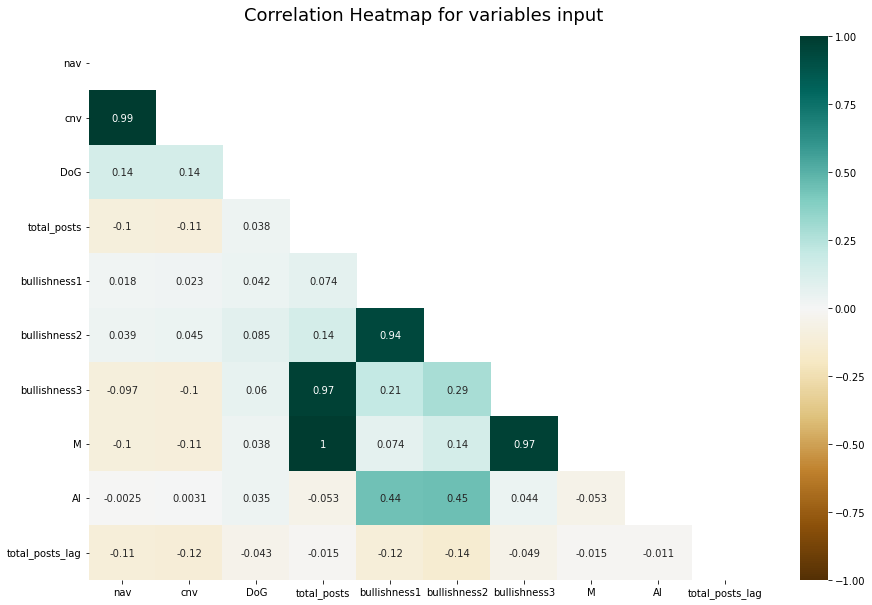

In [ ]:

# define the mask to set the values in the upper triangle to True

plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(final_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(final_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap for variables input', fontdict={'fontsize':18}, pad=16);

In [ ]:
final_data.to_csv("233.csv")

In [ ]:
import pandas as pd

In [ ]:
final_data=pd.read_csv("233.csv")

In [ ]:
final_data

,Unnamed: 0,date,rt,price,sigma,total_posts,total_tweets,vt,pos_f,neg_f,pos_t,neg_t,google_trend,bullishness1,bullishness2,bullishness3,M,AI,total_posts_lag,total_tweets_lag,bullishness1_lag,bullishness2_lag,bullishness3_lag,google_trend_lag,agreement_lag
0,0,2021-05-01,10.963882,57828.050632,10.959442,52.0,1047,24.480655,5.0,11.0,149,158,0,-0.029316,-0.058269,-9,307,0.500430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-05-02,10.965229,56631.077413,10.964882,60.0,966,24.365510,6.0,14.0,157,115,25,0.154412,0.309005,42,272,0.511921,52.0,1047.0,-0.029316,-0.058269,-9.0,0.0,0.500430
2,2,2021-05-03,10.944313,57200.291223,10.945547,86.0,1205,24.668978,8.0,28.0,173,158,43,0.045317,0.090151,15,331,0.501027,60.0,966.0,0.154412,0.309005,42.0,25.0,0.511921
3,3,2021-05-04,10.954314,53333.537753,10.953788,139.0,1224,24.951044,15.0,21.0,177,158,0,0.056716,0.112879,19,335,0.501608,86.0,1205.0,0.045317,0.090151,15.0,43.0,0.501027
4,4,2021-05-05,10.884321,57424.005948,10.888489,75.0,1272,24.960864,9.0,15.0,181,159,0,0.064706,0.128833,22,340,0.502093,139.0,1224.0,0.056716,0.112879,19.0,0.0,0.501608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,210,2021-11-27,10.888740,54815.079305,10.892694,64.0,1480,24.142986,7.0,20.0,185,200,17,-0.038961,-0.077558,-15,385,0.500759,160.0,2222.0,0.098765,0.197359,48.0,17.0,0.504877
211,211,2021-11-28,10.911721,57248.458376,10.910579,87.0,1798,24.059636,13.0,25.0,194,185,17,0.023747,0.047253,9,379,0.500282,64.0,1480.0,-0.038961,-0.077558,-15.0,17.0,0.500759
212,212,2021-11-29,10.955156,57806.566215,10.952481,77.0,2181,24.200524,7.0,27.0,246,272,15,-0.050193,-0.100083,-26,518,0.501260,87.0,1798.0,0.023747,0.047253,9.0,17.0,0.500282
213,213,2021-11-30,10.964858,57005.425474,10.964115,110.0,1882,24.326277,10.0,36.0,240,235,45,0.010526,0.020965,5,475,0.500055,77.0,2181.0,-0.050193,-0.100083,-26.0,15.0,0.501260


Data long time period

In [ ]:
grangers_causation_matrix(data[1:2324], variables=["st","vt","rt","sigma"])

,st_x,vt_x,rt_x,sigma_x
st_y,1.0,0.0000,0.1402,0.1406
vt_y,0.0,1.0000,0.0000,0.0000
rt_y,0.0,0.3364,1.0000,0.1721
sigma_y,0.0,0.3362,0.1273,1.0000


#MODEL

In [ ]:
final_data

,pos_t,neg_t,DoG,pos_l,neg_l,Date,snownlp_senti,lexicon_senti,total_posts,bullishness1_lexicon,bullishness2_lexicon,bullishness3_lexicon,bullishness1_nlp,bullishness2_nlp,bullishness3_nlp
0,5,7,-3.24,10,4,2021/1/11,0.458690,-0.085356,14,0.428571,0.788457,6,-0.166667,-0.287682,-2
1,3,5,3.06,4,5,2021/1/12,0.439028,-0.302030,9,-0.111111,-0.182322,-1,-0.250000,-0.405465,-2
2,3,5,-0.93,7,2,2021/1/13,0.535776,0.001549,9,0.555556,0.980829,5,-0.250000,-0.405465,-2
3,10,5,-3.13,12,5,2021/1/14,0.676551,-0.070055,17,0.411765,0.773190,7,0.333333,0.606136,5
4,3,7,-3.10,10,3,2021/1/15,0.377381,-0.030703,13,0.538462,1.011601,7,-0.400000,-0.693147,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3,3,0.67,6,0,2021/9/30,0.508838,0.902109,6,1.000000,1.945910,6,0.000000,0.000000,0
236,4,4,3.15,7,4,2021/9/6,0.597211,-0.164180,11,0.272727,0.470004,3,0.000000,0.000000,0
237,5,1,0.55,6,1,2021/9/7,0.819785,0.106890,7,0.714286,1.252763,5,0.666667,1.098612,4
238,3,3,-2.08,6,1,2021/9/8,0.515565,0.078623,7,0.714286,1.252763,5,0.000000,0.000000,0


In [ ]:
model1=final_data[["DoG","snownlp_senti","lexicon_senti"]]
model1_diff=model1.diff().dropna()

In [ ]:
model2=final_data[["price","sigma","M","bullishness3","AI"]]
model2_diff=model2.diff().dropna()

In [ ]:
model3=final_data[["price","sigma","vt","neg_t","pos_t","neg_f","pos_f"]]
model3_diff=model3.diff().dropna()

#UNIT ROOT TEST

ADF test

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VARResults

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [ ]:
# ADF on Model1
for name, column in model1_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "DoG" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7266
 No. Lags Chosen       = 12
 Critical value 1%     = -3.46
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "snownlp_senti" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2918
 No. Lags Chosen       = 14
 Critical value 1%     = -3.46
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lexicon_senti" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

In [ ]:
# ADF on Model2
for name, column in model2_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7881
 No. Lags Chosen       = 3
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sigma" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5512
 No. Lags Chosen       = 3
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# ADF on Model3
for name, column in model3_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7881
 No. Lags Chosen       = 3
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sigma" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5512
 No. Lags Chosen       = 3
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "vt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


#LAG LENGTH TEST

In [ ]:
model = VAR(model1_diff)
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar
lag_order

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5

In [ ]:
model = VAR(model2_diff)
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar
lag_order

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4

In [ ]:
model = VAR(model3_diff)
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar
lag_order

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3

#Coin integration test

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
import pandas
from statsmodels.tsa.vector_ar.vecm import VECM, select_order,select_coint_rank

In [ ]:
coin1=select_coint_rank(model1,model1,det_order=0, k_ar_diff=1, method='trace', signif=0.05)

TypeError: ignored

In [ ]:
coin1.summary()

r_0,r_1,test statistic,critical value
0,4,139.0,47.85
1,4,56.72,29.80
2,4,16.17,15.49
3,4,1.893,3.841


In [ ]:
coin2=select_coint_rank(model2, det_order=0, k_ar_diff=1, method='trace', signif=0.05)

In [ ]:
coin2.summary()

r_0,r_1,test statistic,critical value
0,5,215.0,69.82
1,5,128.9,47.85
2,5,50.97,29.80
3,5,9.251,15.49


In [ ]:
coin3=select_coint_rank(model3, det_order=0, k_ar_diff=1, method='trace', signif=0.05)

In [ ]:
coin3.summary()

r_0,r_1,test statistic,critical value
0,7,308.4,125.6
1,7,207.6,95.75
2,7,124.4,69.82
3,7,61.46,47.85
4,7,25.06,29.80


In [ ]:
final_data

,Unnamed: 0,date,rt,price,sigma,total_posts,total_tweets,vt,pos_f,neg_f,pos_t,neg_t,google_trend,bullishness1,bullishness2,bullishness3,M,AI,total_posts_lag,total_tweets_lag,bullishness1_lag,bullishness2_lag,bullishness3_lag,google_trend_lag,agreement_lag
0,0,2021-05-01,10.963882,57828.050632,10.959442,52.0,1047,24.480655,5.0,11.0,149,158,0,-0.029316,-0.058269,-9,307,0.500430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-05-02,10.965229,56631.077413,10.964882,60.0,966,24.365510,6.0,14.0,157,115,25,0.154412,0.309005,42,272,0.511921,52.0,1047.0,-0.029316,-0.058269,-9.0,0.0,0.500430
2,2,2021-05-03,10.944313,57200.291223,10.945547,86.0,1205,24.668978,8.0,28.0,173,158,43,0.045317,0.090151,15,331,0.501027,60.0,966.0,0.154412,0.309005,42.0,25.0,0.511921
3,3,2021-05-04,10.954314,53333.537753,10.953788,139.0,1224,24.951044,15.0,21.0,177,158,0,0.056716,0.112879,19,335,0.501608,86.0,1205.0,0.045317,0.090151,15.0,43.0,0.501027
4,4,2021-05-05,10.884321,57424.005948,10.888489,75.0,1272,24.960864,9.0,15.0,181,159,0,0.064706,0.128833,22,340,0.502093,139.0,1224.0,0.056716,0.112879,19.0,0.0,0.501608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,210,2021-11-27,10.888740,54815.079305,10.892694,64.0,1480,24.142986,7.0,20.0,185,200,17,-0.038961,-0.077558,-15,385,0.500759,160.0,2222.0,0.098765,0.197359,48.0,17.0,0.504877
211,211,2021-11-28,10.911721,57248.458376,10.910579,87.0,1798,24.059636,13.0,25.0,194,185,17,0.023747,0.047253,9,379,0.500282,64.0,1480.0,-0.038961,-0.077558,-15.0,17.0,0.500759
212,212,2021-11-29,10.955156,57806.566215,10.952481,77.0,2181,24.200524,7.0,27.0,246,272,15,-0.050193,-0.100083,-26,518,0.501260,87.0,1798.0,0.023747,0.047253,9.0,17.0,0.500282
213,213,2021-11-30,10.964858,57005.425474,10.964115,110.0,1882,24.326277,10.0,36.0,240,235,45,0.010526,0.020965,5,475,0.500055,77.0,2181.0,-0.050193,-0.100083,-26.0,15.0,0.501260


#VECM

In [ ]:
v1=VECM(model1, dates=None, freq=None, missing='none', k_ar_diff=1, coint_rank=3, deterministic='n', seasons=0, first_season=0)
vecm_res1 = v1.fit()
vecm_res1.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,0.0068,0.072,0.094,0.925,-0.134,0.147
L1.vt,619.7759,870.067,0.712,0.476,-1085.524,2325.076
L1.pos_t,-12.1078,3.859,-3.138,0.002,-19.671,-4.544
L1.neg_t,9.2495,3.075,3.008,0.003,3.224,15.276
,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,-1.013e-05,7.67e-06,-1.320,0.187,-2.52e-05,4.91e-06
L1.vt,-0.2724,0.093,-2.926,0.003,-0.455,-0.090
L1.pos_t,0.0007,0.000,1.655,0.098,-0.000,0.001
L1.neg_t,0.0002,0.000,0.458,0.647,-0.000,0.001
,coef,std err,z,P>|z|,[0.025,0.975]


In [ ]:
v2=VECM(model2, exog_coint=None, dates=None, freq=None, missing='none', k_ar_diff=1, coint_rank=3, deterministic='n', seasons=0, first_season=0)
vecm_res2 = v2.fit()
vecm_res2.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,-0.0230,0.074,-0.310,0.757,-0.168,0.122
L1.sigma,-575.5584,3458.954,-0.166,0.868,-7354.984,6203.867
L1.M,-1.0618,1.178,-0.901,0.367,-3.371,1.247
L1.bullishness3,-11.6064,3.244,-3.578,0.000,-17.965,-5.248
L1.AI,-5458.2431,1.6e+04,-0.341,0.733,-3.68e+04,2.59e+04
,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,1.988e-05,3.08e-07,64.550,0.000,1.93e-05,2.05e-05
L1.sigma,0.0554,0.014,3.852,0.000,0.027,0.084
L1.M,-4.333e-06,4.9e-06,-0.885,0.376,-1.39e-05,5.27e-06
L1.bullishness3,2.91e-05,1.35e-05,2.158,0.031,2.67e-06,5.55e-05


In [ ]:
v3=VECM(model3, exog_coint=None, dates=None, freq=None, missing='none', k_ar_diff=1, coint_rank=4, deterministic='n', seasons=0, first_season=0)
vecm_res3 = v3.fit()
vecm_res3.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,-0.0035,0.080,-0.043,0.966,-0.160,0.153
L1.sigma,1935.1556,3573.814,0.541,0.588,-5069.390,8939.701
L1.vt,1149.2902,922.095,1.246,0.213,-657.982,2956.562
L1.neg_t,12.2169,3.570,3.422,0.001,5.220,19.214
L1.pos_t,-12.7342,4.119,-3.092,0.002,-20.807,-4.661
L1.neg_f,-39.1328,18.448,-2.121,0.034,-75.291,-2.975
L1.pos_f,-0.1603,35.072,-0.005,0.996,-68.900,68.579
,coef,std err,z,P>|z|,[0.025,0.975]
L1.price,2.046e-05,3.35e-07,61.028,0.000,1.98e-05,2.11e-05
L1.sigma,0.0503,0.015,3.353,0.001,0.021,0.080
